COPYRIGHT NOTICE
In the name of Christ our Lord be blessed. We, Joshuah Rainstar(joshuah.rainstar@gmail.com), do claim copyright to this code, or software, and associated documentation, as our work in the year 2025 Anno Domini, reserving all rights and assigning them in accordance with the following license terms:

1. Permission is by our authority and with this statement granted, to any person or artificial intelligence without limitation or restriction to examine, analyze, read, dissect, translate, use, modify, and distribute the aforementioned copyrighted items, subject to the following conditions:
2. This license must be included in full with any copies or works containing substantial portions of the copyrighted items.
3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.


THE COPYRIGHTED ITEMS ARE PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE COPYRIGHTED ITEMS OR THEIR USE OR ANY OTHER CIRCUMSTANCES CONCERNING THEM.


this is an experimental model intended to elucidate possible mechanics for attention across sequences in addition to tokenwise. it is reasonably fast and efficient. conceptually, the design was envisioned by me and coded through refinement with OpenAI Codex Orion One and chatgpt

"hierarchical multi-scale transformer with MoE-like sparse selection"

SelfScalableTanh from  Self-scalable Tanh (Stan): Faster Convergence and Better Generalization in Physics-informed Neural Networks
https://arxiv.org/abs/2204.1258
Motivation: my gut said its a good idea. Impact: little bit faster convergence even in gpt9
harmonic loss from  Harmonic Loss Trains Interpretable AI Models
https://arxiv.org/abs/2502.01628note that I do the math in log space to avoid explosions
note that harmonic loss has been swapped for a student's t distribution to avoid NaN collapses near zero
motivation: interpretable model. Impact: speeds up convergence even more than harmonic!

XOR from  Two-argument activation functions learn soft XOR operations like cortical neurons
https://arxiv.org/abs/2110.06871note that my implementation is a differential XOR for backprop capability
motivation: little bit of internal reasoning maybe? Impact: slows down convergence somewhat

WOLF optimizer experimental by me, it may not beat adam but it is simpler than adam, closer to SGD with some smoothing of integration
impact: speeds up convergence somewhat for early iterations and will not NAN from high LR.
probable benefit- switch optimizers after model drops. could be good for bigger models.. maybe

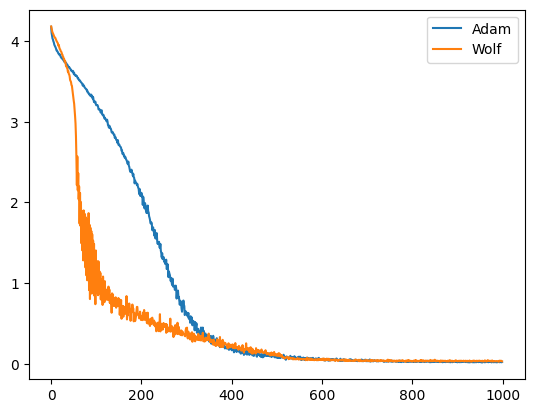
m 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
import math
import requests

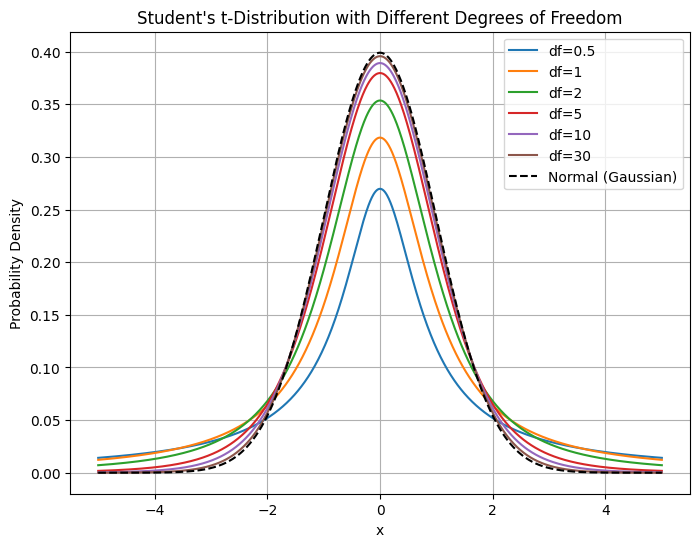

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Define degrees of freedom to test
dfs = [0.5, 1, 2, 5, 10, 30]  # Lower df = heavier tails

# Define x-axis range
x = np.linspace(-5, 5, 1000)

# Generate and plot Student's t-distribution for each df
plt.figure(figsize=(8, 6))
for df in dfs:
    pdf = stats.t.pdf(x, df)
    plt.plot(x, pdf, label=f"df={df}")

# Plot standard normal distribution for reference
normal_pdf = stats.norm.pdf(x, 0, 1)
plt.plot(x, normal_pdf, '--', label="Normal (Gaussian)", color='black')

# Labels and legend
plt.title("Student's t-Distribution with Different Degrees of Freedom")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [69]:


from torch.optim.optimizer import Optimizer
class Wolf(Optimizer):
    """Implements Wolf algorithm."""
    def __init__(self, params, lr=0.25, betas=(0.9, 0.999), eps=1e-8):
        # Define default parameters
        defaults = dict(lr=lr, betas=betas, eps=eps)
        self.lr = lr
        # Initialize the parent Optimizer class first
        super().__init__(params, defaults)
        # Constants specific to Wolf
        # Initialize state for each parameter
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['p'] = torch.zeros_like(p)  # Second moment estimate


    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step and adjusts dropout in transformer blocks."""
        etcerta = 0.367879441  # Constant used in update rule
        et = 1 - etcerta
    
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
    
        # Iterate over parameter groups.
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad
    
                #  AMP Compatibility: Check for NaN or Inf in gradients
                if torch.isnan(grad).any() or torch.isinf(grad).any():
                    print("Skipping parameter update due to NaN/Inf gradient.")
                    continue  # Skip this update if the gradient has NaN or Inf
    
                state = self.state[p]
                exp_avg = state['p']
    
                # Compute update and update second moment-like state.
                update = exp_avg * et + grad * etcerta
                state['p'] = exp_avg * et + update * etcerta
    
                # Compute sign agreement between update and gradient.
                sign_agreement = torch.sign(update) * torch.sign(grad)
    
                # Where the signs agree (mask is True), update the parameter.
                mask = (sign_agreement > 0)
                adaptive_alpha = group.get('lr', self.lr)
                p.data = torch.where(mask, p.data - adaptive_alpha * update, p.data)
    
                # AMP Compatibility: Ensure a step counter is updated
                state['step'] = state.get('step', 0) + 1  # Track optimization steps
    
        return loss



def student_t_unembedding(hidden_states, unembedding, df=30.0, eps=1e-9):
    """
    Student's t-based unembedding.
    
    Arguments:
      hidden_states: (B, S, D)  => model’s output embeddings
      unembedding:   (D, V)    => learnable "word vectors" or unembedding
      df (float): degrees of freedom for the Student's t distribution
      eps (float): numerical epsilon to avoid log(0) and div-by-zero

    Returns:
      p: (B, S, V)  probability distribution over V vocabulary tokens.
    """
    B, S, D = hidden_states.shape
    V = unembedding.shape[1]

    # Expand hidden => (B, S, 1, D)
    x_expanded = hidden_states.unsqueeze(2)
    # Expand unembedding => (1,1,V,D)
    w_expanded = unembedding.t().unsqueeze(0).unsqueeze(0)  # => (1, 1, V, D)
    
    # Squared distance
    dist_sq = torch.sum((x_expanded - w_expanded)**2, dim=-1).clamp(min=1e-6)

    # Negative energy = -log( p(w|x) ) up to constant:
    #     E = 0.5*(df + D) * log(1 + dist_sq / df)
    # We want log( p ) = -E => 
    #   log_p = -0.5*(df + D)*log(1 + dist_sq/df)
    
    log_p_unnorm = -0.5 * (df + D) * torch.log1p(dist_sq / df)  # (B, S, V)
    
    # Normalize via log_softmax over vocabulary dimension
    log_p = F.log_softmax(log_p_unnorm, dim=-1)  # (B, S, V)
    p = log_p.exp()
    return p
# ---------------------------------------------------
# Custom Activation
# ---------------------------------------------------
class SelfScalableTanh(nn.Module):
    def __init__(self, init_scale=0.1, max_scale=0.12):
        super().__init__()
        # Learned scale parameter
        self.scale = nn.Parameter(torch.tensor(init_scale, dtype=torch.float32))

    def forward(self, x):
        # "Scaled Tanh"
        scale = torch.clamp(self.scale,0.0,1.0)#prevent NaN collapse
        return torch.tanh(x) + scale * torch.tanh(x)


# ---------------------------------------------------
# Differentiable XOR
# ---------------------------------------------------
class DifferentiableXORLayer(nn.Module):
    """
    Splits the incoming embedding in half, and does a
    sigmoid-based XOR-like transformation.
    """
    def __init__(self, embed_dim):
        super().__init__()
        assert embed_dim % 2 == 0, "embed_dim must be even for XOR."
        self.embed_dim = embed_dim
        self.proj = nn.Linear(embed_dim // 2, embed_dim)

    def forward(self, x):
        d = self.embed_dim // 2
        x1, x2 = x[..., :d], x[..., d:]
        a = torch.sigmoid(x1)
        b = torch.sigmoid(x2)
        # approximate XOR = a + b - 2ab
        xor_out = 0.5 * (a + b - 2 * a * b)  # scaled by 0.5
        out = self.proj(xor_out)
        return out




class TapeHead(nn.Module):
    """
    A single head that attends over chunked embeddings of size `chunk_size`.
    """
    def __init__(self, embed_dim, chunk_size=2, num_heads=1, dropout=0.0):
        super().__init__()
        self.embed_dim = embed_dim
        self.chunk_size = chunk_size
        self.num_heads = num_heads

        # Project c * D => D to build a chunk embedding
        self.chunk_proj = nn.Linear(chunk_size * embed_dim, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.ln = nn.LayerNorm(embed_dim)
        
    def forward(self, token_emb):
        """
        token_emb: (B, S, D)
        Returns (B, S, D)
        """
        B, S, D = token_emb.shape
        c = self.chunk_size  # e.g. 2, 4, ...
    
        # 1) Move channel/feature dim (D) before the sequence dim (S).
        #    So x_3d is (B, D, S).
        x_3d = token_emb.permute(0, 2, 1)
    
        # 2) Pad the sequence dimension on the RIGHT with (c - 1) zeros.
        #    That matches your original "end" padding if i + c > S.
        #    F.pad takes (left_pad, right_pad) on the last dimension
        #    so we do (0, c - 1).
        x_3d_padded = F.pad(x_3d, (0, c - 1))  # => (B, D, S + c - 1)
    
        # 3) Unfold with kernel_size=(c, 1), stride=(1, 1), no extra padding=...
        #    This "slides" a c-sized window along the (S + c - 1) dimension.
        #    We'll end up with exactly S windows.
        #    x_3d_padded.unsqueeze(-1) => shape (B, D, S+c-1, 1).
        unfolded = F.unfold(
            x_3d_padded.unsqueeze(-1),
            kernel_size=(c, 1),
            stride=(1, 1),
            padding=(0, 0),
        )
        # `unfolded` => (B, D*c, S)
    
        # 4) Transpose so that we have (B, S, D*c).
        unfolded = unfolded.transpose(1, 2)  # (B, S, D*c)
    
        # 5) Project down to (B, S, D).  Each "window" becomes one chunk embedding.
        chunk_tensor = self.chunk_proj(unfolded)  # => (B, S, D)
        # 6) Standard self-attention on (B, S, D).
        out, _ = self.attn(chunk_tensor, chunk_tensor, chunk_tensor)
        out = self.ln(chunk_tensor + out)
        return out



class MultiScaleTapeAttention(nn.Module):
    """
    Combines multiple TapeHeads of different chunk sizes (including c=1 for token-level).
    """
    def __init__(self, embed_dim, chunk_sizes=(1,2,4), num_heads=2, dropout=0.0):
        super().__init__()
        self.heads = nn.ModuleList([
            TapeHead(embed_dim, c, num_heads=num_heads, dropout=dropout)
            for c in chunk_sizes
        ])
        # We'll fuse the outputs from each head
        total_dim = len(chunk_sizes) * embed_dim
        self.fuse = nn.Linear(total_dim, embed_dim)
        self.ln = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # x: (B, S, D)
        out_heads = []
        for head in self.heads:
            out_heads.append(head(x))
        # cat in feature dim => shape (B, S, total_dim)
        cat_out = torch.cat(out_heads, dim=-1)
        fused = self.fuse(cat_out)
        fused = self.ln(fused)
        return fused


class MultiScaleTransformerBlock(nn.Module):
    """
    A single block that:
      - Applies multi-scale "Tape" self-attention
      - Then an MLP with SelfScalableTanh
      - Then a DifferentiableXOR gating
      - Then LN + residual
    """
    def __init__(self, embed_dim, chunk_sizes=(1,2,4), num_heads=2, dropout=0.1, res_scale=1.0):
        super().__init__()
        # Multi-scale attention
        self.attn = MultiScaleTapeAttention(
            embed_dim, chunk_sizes=chunk_sizes, num_heads=num_heads, dropout=dropout
        )
        self.ln1 = nn.LayerNorm(embed_dim)

        # MLP
        self.activation = SelfScalableTanh()
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            self.activation,
            nn.Linear(4 * embed_dim, embed_dim),
            nn.Dropout(dropout)
        )
        # XOR gating
        self.ln2 = nn.LayerNorm(embed_dim)
        self.res_scale = res_scale

    def forward(self, x):
        # x shape: (B, S, D)
        attn_out = self.attn(x)
        # Residual + LN
        x = self.ln1(x + self.res_scale * attn_out)

        # MLP
        mlp_out = self.mlp(x)
        # second residual + LN
        x = self.ln2(x + self.res_scale * mlp_out)
        return x


class ChunkModule(nn.Module):
    """
    A transformer-based processing module that operates on a specific chunk size.
    Each layer has its own XOR layer, applied recursively.
    """
    def __init__(self, embed_dim, num_layers, chunk_size, num_heads=2, dropout=0.1):
        super().__init__()
        self.chunk_size = chunk_size
        self.embed_dim = embed_dim

        # Stack of Transformer layers (specific to this chunk size)
        self.blocks = nn.ModuleList([
            MultiScaleTransformerBlock(
                embed_dim=embed_dim,
                chunk_sizes=(chunk_size,),  # This module only processes its chunk size
                num_heads=num_heads,
                dropout=dropout
            ) for _ in range(num_layers)
        ])

        # **New: Individual XOR layer per transformer block**
        self.xor_layers = nn.ModuleList([
            DifferentiableXORLayer(embed_dim) for _ in range(num_layers)
        ])

    def forward(self, x):
        """
        x: (B, S, D) - Input sequence representation
        Returns:
          h: (B, S, D) - Processed sequence after chunk-based attention
        """
        # **Process through transformer layers recursively**
        for i, block in enumerate(self.blocks):
            x = block(x)  # Transformer processing
            x = self.xor_layers[i](x)  # Apply XOR for this layer

        return x  # Return final processed state



class MultiScaleTapeModel(nn.Module):
    """
    A hierarchical transformer model where different ChunkModules attend to different chunk sizes.
    The outputs of all modules are blended based on confidence.
    """
    def __init__(self,
                 vocab_size,
                 seq_len=256,
                 embed_dim=512,
                 num_layers=8,
                 chunk_sizes=(1,2,4,8,16),  # Different scales
                 num_heads=8,
                 dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.chunk_sizes = chunk_sizes

        # Token & position embeddings
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_emb = nn.Parameter(torch.zeros(1, seq_len, embed_dim))

        # Create a separate ChunkModule for each chunk size
        self.chunk_modules = nn.ModuleList([
            ChunkModule(embed_dim=embed_dim,
                        num_layers=num_layers,
                        chunk_size=c,
                        num_heads=num_heads,
                        dropout=dropout)
            for c in chunk_sizes
        ])

        # Separate unembedding per module
        self.unembeddings = nn.ParameterList([
            nn.Parameter(torch.randn(embed_dim, vocab_size))
            for _ in range(len(chunk_sizes))
        ])
        for unembedding in self.unembeddings:
            nn.init.kaiming_uniform_(unembedding, a=math.sqrt(5))

    def forward(self, x):
        """
        x: (B, S) int tokens
        Returns:
          p: (B, S, V) final probability distribution (confidence-weighted)
        """
        B, S = x.shape
        assert S <= self.seq_len, "Input seq too long for pos_emb."

        # 1) Token embeddings
        tok_emb = self.token_emb(x)                # (B, S, D)
        pos_slice = self.pos_emb[:, :S, :]         # (1, S, D)
        h = tok_emb + pos_slice                    # (B, S, D)

        # 2) Process through each ChunkModule independently
        h_chunks = []
        for chunk_module in self.chunk_modules:
            h_chunk = chunk_module(h)  # Each chunk module processes independently
            h_chunks.append(h_chunk)

        # Stack across chunk modules: (H, B, S, D)
        h_stack = torch.stack(h_chunks, dim=0)

        # 3) Compute each module's output probabilities
        p_chunks = []
        for i, unembedding in enumerate(self.unembeddings):
            p_chunk = student_t_unembedding(h_stack[i], unembedding, df=30.0)  # (B, S, V)
            p_chunks.append(p_chunk)
        p_stack = torch.stack(p_chunks, dim=0)  # (H, B, S, V)

        # 4) Compute confidence scores from distributions (Entropy-based)
        log_p_stack = (p_stack + 1e-9).log()  # Avoid log(0)
        entropy = -torch.sum(p_stack * log_p_stack, dim=-1)  # (H, B, S)
        c_stack = 1.0 - (entropy / math.log(self.vocab_size))  # (H, B, S)

        # 5) Softmax over confidence scores to get weights (differentiable)
        alpha = F.softmax(c_stack, dim=0)  # Normalize over chunk modules: (H, B, S)

        # 6) Compute final probability distribution via weighted sum
        # Get the best chunk module index per (B, S) position
        best_chunks = alpha.argmax(dim=0)  # (B, S)
        
        # Use advanced indexing to select the best prediction
        b_idx = torch.arange(B, device=x.device).unsqueeze(1).expand(B, S)
        s_idx = torch.arange(S, device=x.device).unsqueeze(0).expand(B, S)
        
        # Select the highest-confidence chunk module's prediction for each token
        p_final = p_stack[best_chunks, b_idx, s_idx]  # (B, S, V)

        return p_final



In [70]:
import gc,torch

gc.collect()
torch.cuda.empty_cache()

In [74]:
# ====================================================
# Data Preparation (Shakespeare)
# ====================================================
def load_shakespeare_text():
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    text = requests.get(url).text
    return text

text = load_shakespeare_text()
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}


def encode(s):
    return [stoi[c] for c in s]

def decode(l):
    return ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)

def get_batch(batch_size, seq_len):
    ix = torch.randint(0, data.size(0) - seq_len - 1, (batch_size,))
    x = torch.stack([data[i:i+seq_len] for i in ix])
    y = torch.stack([data[i+1:i+seq_len+1] for i in ix])
    return x, y

# ====================================================
# Training Setup
# ====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiScaleTapeModel(
    vocab_size=vocab_size,  # example
    seq_len=256,
    embed_dim=384,
    num_layers=6,
    chunk_sizes=(1,2,4),
    num_heads=6,
    dropout=0.0
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=6e-4)

scaler = GradScaler()

num_epochs = 100
batch_size = 16
seq_len = 256 #from karapathy


losses = []


In [75]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

42361362

In [ ]:
optimizer.lr = 0.01
for epoch in range(num_epochs):

    model.train()

    total_loss = 0.0
    for step in range(1000):  # Adjust the number of steps as needed.
        x_batch, y_batch = get_batch(batch_size, seq_len)
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        with autocast():
            p = model(x_batch)
            loss = -torch.log(torch.gather(p, -1, y_batch.unsqueeze(-1)) + 1e-8).squeeze(-1).mean()

        main_loss = loss.detach()

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += main_loss
        losses.append(main_loss.cpu())
        if step % 1 == 0:
            print(f"Epoch {epoch+1}, Step {step}, Loss: {main_loss:.4f}")

    print(f"Epoch {epoch+1} Average Loss: {total_loss/100:.4f}")

# ====================================================
# Evaluation: Text Generation
# ====================================================

model.eval()
with torch.no_grad():
    prompt = "oh Romeo! Romeo!"
    context = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    generated = context
    for _ in range(200):  # Generate 200 tokens.
        inp = generated[:, -seq_len:]
        p = model(inp)  # p: (B, seq, vocab_size)
        last_token_probs = p[:, -1, :]  # Shape: [batch_size, vocab_size]
        next_token = torch.multinomial(last_token_probs, num_samples=1)
        generated = torch.cat((generated, next_token), dim=1)
    sample = decode(generated[0].cpu().tolist())
    print("Generated Sample:\n", sample)


Epoch 1, Step 0, Loss: 6.0383
Epoch 1, Step 1, Loss: 5.0215
Epoch 1, Step 2, Loss: 5.8064
Epoch 1, Step 3, Loss: 5.2529
Epoch 1, Step 4, Loss: 4.5665
Epoch 1, Step 5, Loss: 4.8350
Epoch 1, Step 6, Loss: 4.6217
Epoch 1, Step 7, Loss: 4.7356
Epoch 1, Step 8, Loss: 5.3902
Epoch 1, Step 9, Loss: 4.5783
Epoch 1, Step 10, Loss: 4.9874
Epoch 1, Step 11, Loss: 6.3217
Epoch 1, Step 12, Loss: 4.2262
Epoch 1, Step 13, Loss: 4.2458
Epoch 1, Step 14, Loss: 5.8019
Epoch 1, Step 15, Loss: 4.2438
Epoch 1, Step 16, Loss: 3.9479
Epoch 1, Step 17, Loss: 5.0797
Epoch 1, Step 18, Loss: 4.5807
Epoch 1, Step 19, Loss: 4.4357
Epoch 1, Step 20, Loss: 4.2104
Epoch 1, Step 21, Loss: 5.0882
Epoch 1, Step 22, Loss: 3.9761
Epoch 1, Step 23, Loss: 4.8927
Epoch 1, Step 24, Loss: 3.8278
Epoch 1, Step 25, Loss: 3.7386
Epoch 1, Step 26, Loss: 3.5204
Epoch 1, Step 27, Loss: 3.4903
Epoch 1, Step 28, Loss: 4.4803
Epoch 1, Step 29, Loss: 4.1497
Epoch 1, Step 30, Loss: 4.2241
Epoch 1, Step 31, Loss: 3.8660
Epoch 1, Step 32, 

In [66]:
model.eval()
with torch.no_grad():
    prompt = "oh Romeo! Romeo!"
    context = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    generated = context
    for _ in range(200):  # Generate 200 tokens.
        inp = generated[:, -seq_len:]
        p = model(inp)  # p: (B, seq, vocab_size)
        last_token_probs = p[:, -1, :]  # Shape: [batch_size, vocab_size]
        next_token = torch.multinomial(last_token_probs, num_samples=1)
        generated = torch.cat((generated, next_token), dim=1)
    sample = decode(generated[0].cpu().tolist())
    print("Generated Sample:\n", sample)


Generated Sample:
 oh Romeo! Romeo! disererstt k ldNerther;
KEHindand;
Antitto s thos aostisghER-sthom,
I-d tflond tcSoulll'egh fand,
:
q
IHhighthisd,
?-seitte mithe whillsounngimenghonccg qncondanthrehewet!
Hanuyt pif ps touellrt,
Han


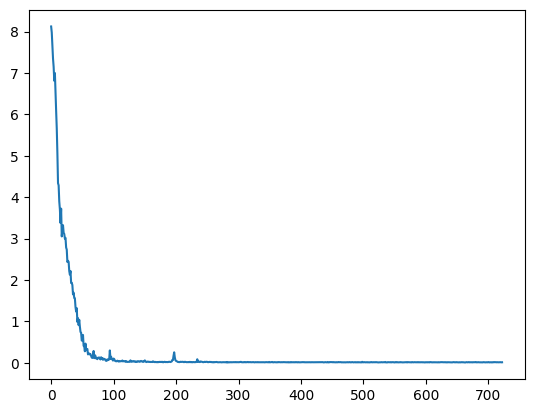

In [67]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.show()